In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('Set2')


In [3]:
"""0. Preparation"""

regions = ['asahi', 'narita', 'ichihara', 'katori', 'sanmu']
climate_data = {}
yield_data = {}
dir = '../data/raw/'

In [4]:
"""1. Load data and process datetime"""

for region in regions:
    # Load climate data
    climate_file = dir + f'{region}_climate_df.csv'
    climate_data[region] = pd.read_csv(climate_file)
    
    # Change date type and extract year/month
    climate_data[region]['date'] = pd.to_datetime(climate_data[region]['valid_time'])
    climate_data[region]['year'] = climate_data[region]['date'].dt.year
    climate_data[region]['month'] = climate_data[region]['date'].dt.month
    
    # Load yield data
    yield_file = dir + f'{region}_yields_df.csv'
    yield_data[region] = pd.read_csv(yield_file)
    
    print(f"{region} - 気象データ期間: {climate_data[region]['year'].min()} ~ {climate_data[region]['year'].max()}")
    print(f"{region} - 収穫データ期間: {yield_data[region]['Year'].min()} ~ {yield_data[region]['Year'].max()}")
    print(f"{region} - 収穫データ件数: {len(yield_data[region])}")
    print('-' * 50)


asahi - 気象データ期間: 1990 ~ 2023
asahi - 収穫データ期間: 1993 ~ 2023
asahi - 収穫データ件数: 31
--------------------------------------------------
narita - 気象データ期間: 1990 ~ 2023
narita - 収穫データ期間: 1993 ~ 2023
narita - 収穫データ件数: 31
--------------------------------------------------
ichihara - 気象データ期間: 1990 ~ 2023
ichihara - 収穫データ期間: 1993 ~ 2023
ichihara - 収穫データ件数: 31
--------------------------------------------------
katori - 気象データ期間: 1990 ~ 2023
katori - 収穫データ期間: 1993 ~ 2023
katori - 収穫データ件数: 31
--------------------------------------------------
sanmu - 気象データ期間: 1990 ~ 2023
sanmu - 収穫データ期間: 1993 ~ 2023
sanmu - 収穫データ件数: 31
--------------------------------------------------


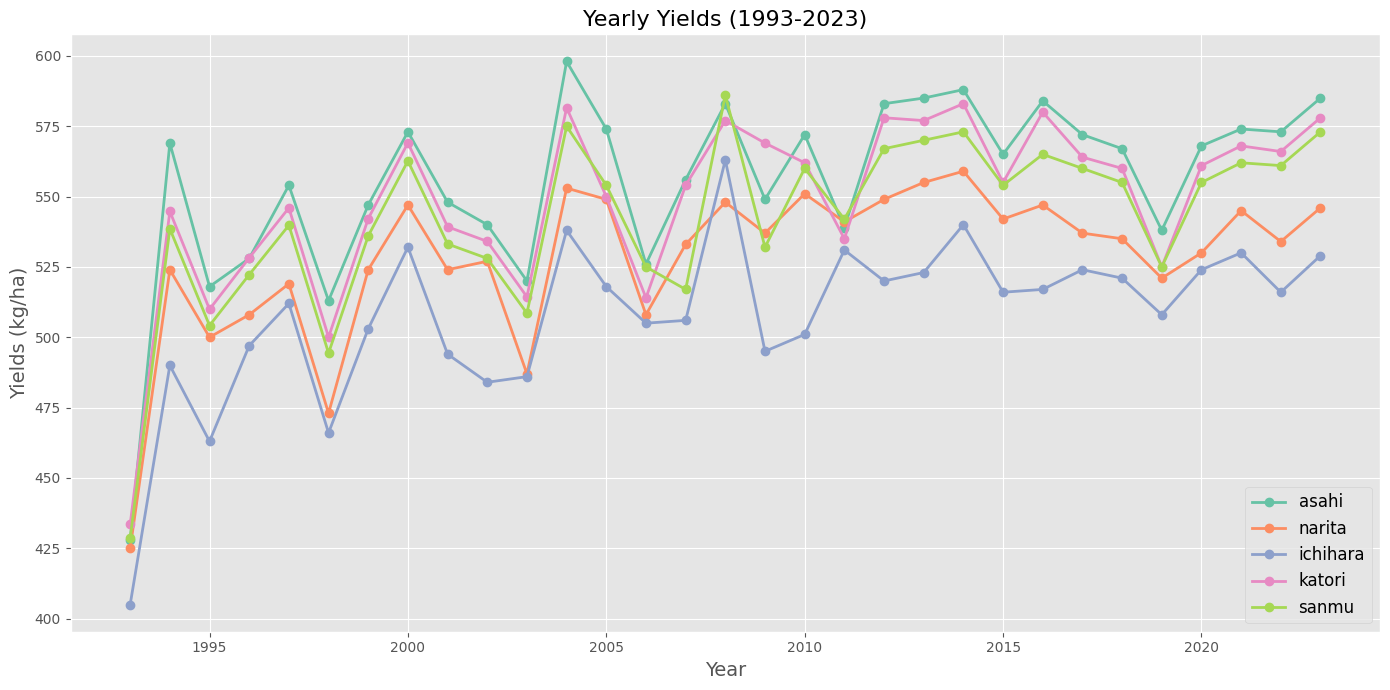

In [5]:
"""2. Yield trend visualization"""
plt.figure(figsize=(14, 7))
for region in regions:
    plt.plot(yield_data[region]['Year'], yield_data[region]['Yields'], marker='o', linewidth=2, label=region)

plt.title('Yearly Yields (1993-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Yields (kg/ha)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
"""3. Aggregate climate data by stages"""

def aggregate_climate_by_stage(climate_df):
    # Define stages
    stages = {
        'preparation': [1, 2, 3, 4],  # 1-4月: 準備期
        'planting': [5],              # 5月: 田植え期
        'growing': [6, 7],            # 6-7月: 生育期
        'heading': [8, 9],            # 8-9月: 出穂・登熟期
        'harvesting': [10]            # 10月: 収穫期
    }

    result = pd.DataFrame()
    
    # Aggregate data by each stage
    for stage, months in stages.items():
        
        # Filter
        stage_data = climate_df[climate_df['month'].isin(months)]
        
        # Aggregate by year
        agg_data = stage_data.groupby('year').agg({
            'temp_2m': 'mean',
            'soil_temp_l1': 'mean',
            'soil_water_vol_l1': 'mean',
            'net_solar_radiation': 'sum',
            'total_rain': 'sum'
        }).reset_index()
        
        # Change columns
        agg_data.columns = ['year'] + [f'{stage}_{col}' for col in agg_data.columns[1:]]
        
        if result.empty:
            result = agg_data
        else:
            result = pd.merge(result, agg_data, on='year')
    
    return result

In [7]:
"""4. Aggregate and combine with each region"""
combined_data = []


In [8]:
for region in regions:
    # Aggregate by stage
    stage_climate = aggregate_climate_by_stage(climate_data[region])
    
    # Merge with yield data
    merged = pd.merge(stage_climate, yield_data[region][['Year', 'Yields']], 
                     left_on='year', right_on='Year')
    
    # Add region info
    merged['region'] = region
    
    # Append to merged data
    combined_data.append(merged)

In [9]:
all_data = pd.concat(combined_data, ignore_index=True)
print(f"Data size: {all_data.shape}")

Data size: (155, 29)


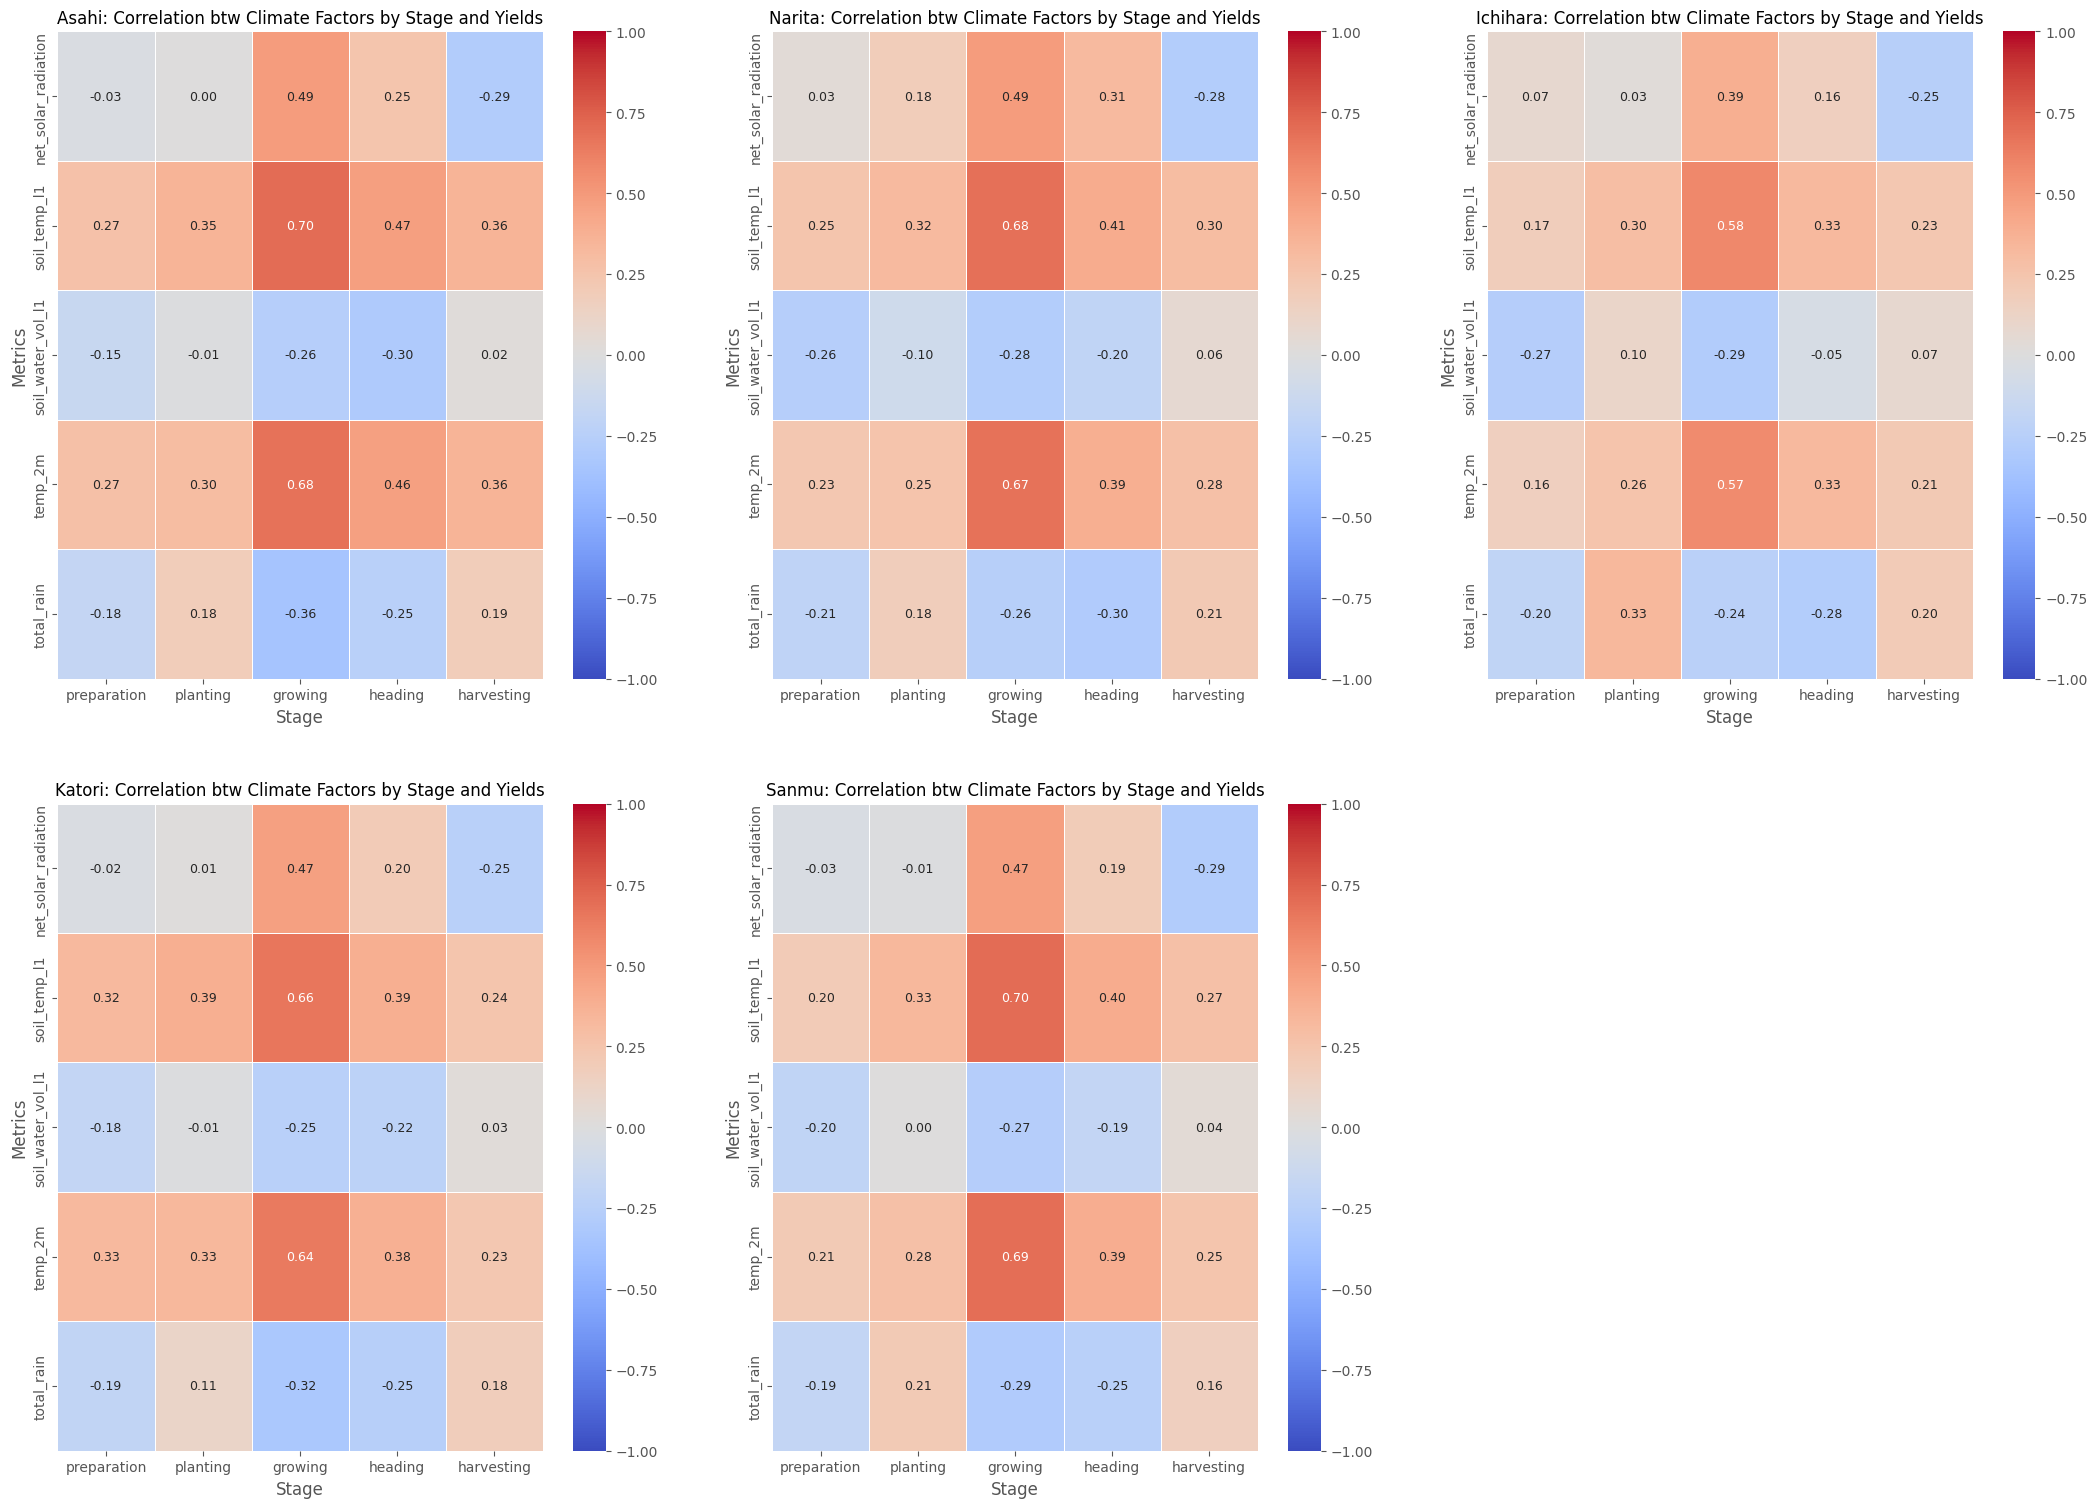

In [11]:
"""5. Correlation Analysis"""

plt.figure(figsize=(22, 16))

# Correlation array
climate_cols = [col for col in all_data.columns
                if any(stage in col for stage in ['preparation_', 'planting_', 'growing_', 'heading_', 'harvesting_'])]
correlation_cols = [col for col in all_data.columns 
                   if any(stage in col for stage in ['preparation_', 'planting_', 'growing_', 'heading_', 'harvesting_'])]

# Analyze correlation by region
for i, region in enumerate(regions):
    region_data = all_data[all_data['region'] == region]
    
    # Calculate correlation between yields and climate factors
    corr_values = {}
    for col in correlation_cols:
        corr_values[col] = region_data[['Yields', col]].corr().iloc[0, 1]
        
    corr_df = pd.DataFrame({'Feature': list(corr_values.keys()),
                            'Correlation': list(corr_values.values())})
    
    # Divide features into stages and indicator type
    corr_df['Stage'] = corr_df['Feature'].apply(lambda x: x.split('_')[0])
    corr_df['Metrics'] = corr_df['Feature'].apply(lambda x: '_'.join(x.split('_')[1:]))
    
    # pivot
    pivot_df = corr_df.pivot(index='Metrics', columns='Stage', values='Correlation')
    
    # Order stages
    stage_order = ['preparation', 'planting', 'growing', 'heading', 'harvesting']
    pivot_df = pivot_df[stage_order]
    
    plt.subplot(2, 3, i+1)
    
    sns.heatmap(pivot_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
                fmt='.2f', linewidth=0.5, cbar=True, annot_kws={'size': 9})
    plt.title(f'{region.capitalize()}: Correlation btw Climate Factors by Stage and Yields', fontsize=12)
    
plt.tight_layout(pad=4.0)
plt.show()

In [12]:
climate_cols

['preparation_temp_2m',
 'preparation_soil_temp_l1',
 'preparation_soil_water_vol_l1',
 'preparation_net_solar_radiation',
 'preparation_total_rain',
 'planting_temp_2m',
 'planting_soil_temp_l1',
 'planting_soil_water_vol_l1',
 'planting_net_solar_radiation',
 'planting_total_rain',
 'growing_temp_2m',
 'growing_soil_temp_l1',
 'growing_soil_water_vol_l1',
 'growing_net_solar_radiation',
 'growing_total_rain',
 'heading_temp_2m',
 'heading_soil_temp_l1',
 'heading_soil_water_vol_l1',
 'heading_net_solar_radiation',
 'heading_total_rain',
 'harvesting_temp_2m',
 'harvesting_soil_temp_l1',
 'harvesting_soil_water_vol_l1',
 'harvesting_net_solar_radiation',
 'harvesting_total_rain']

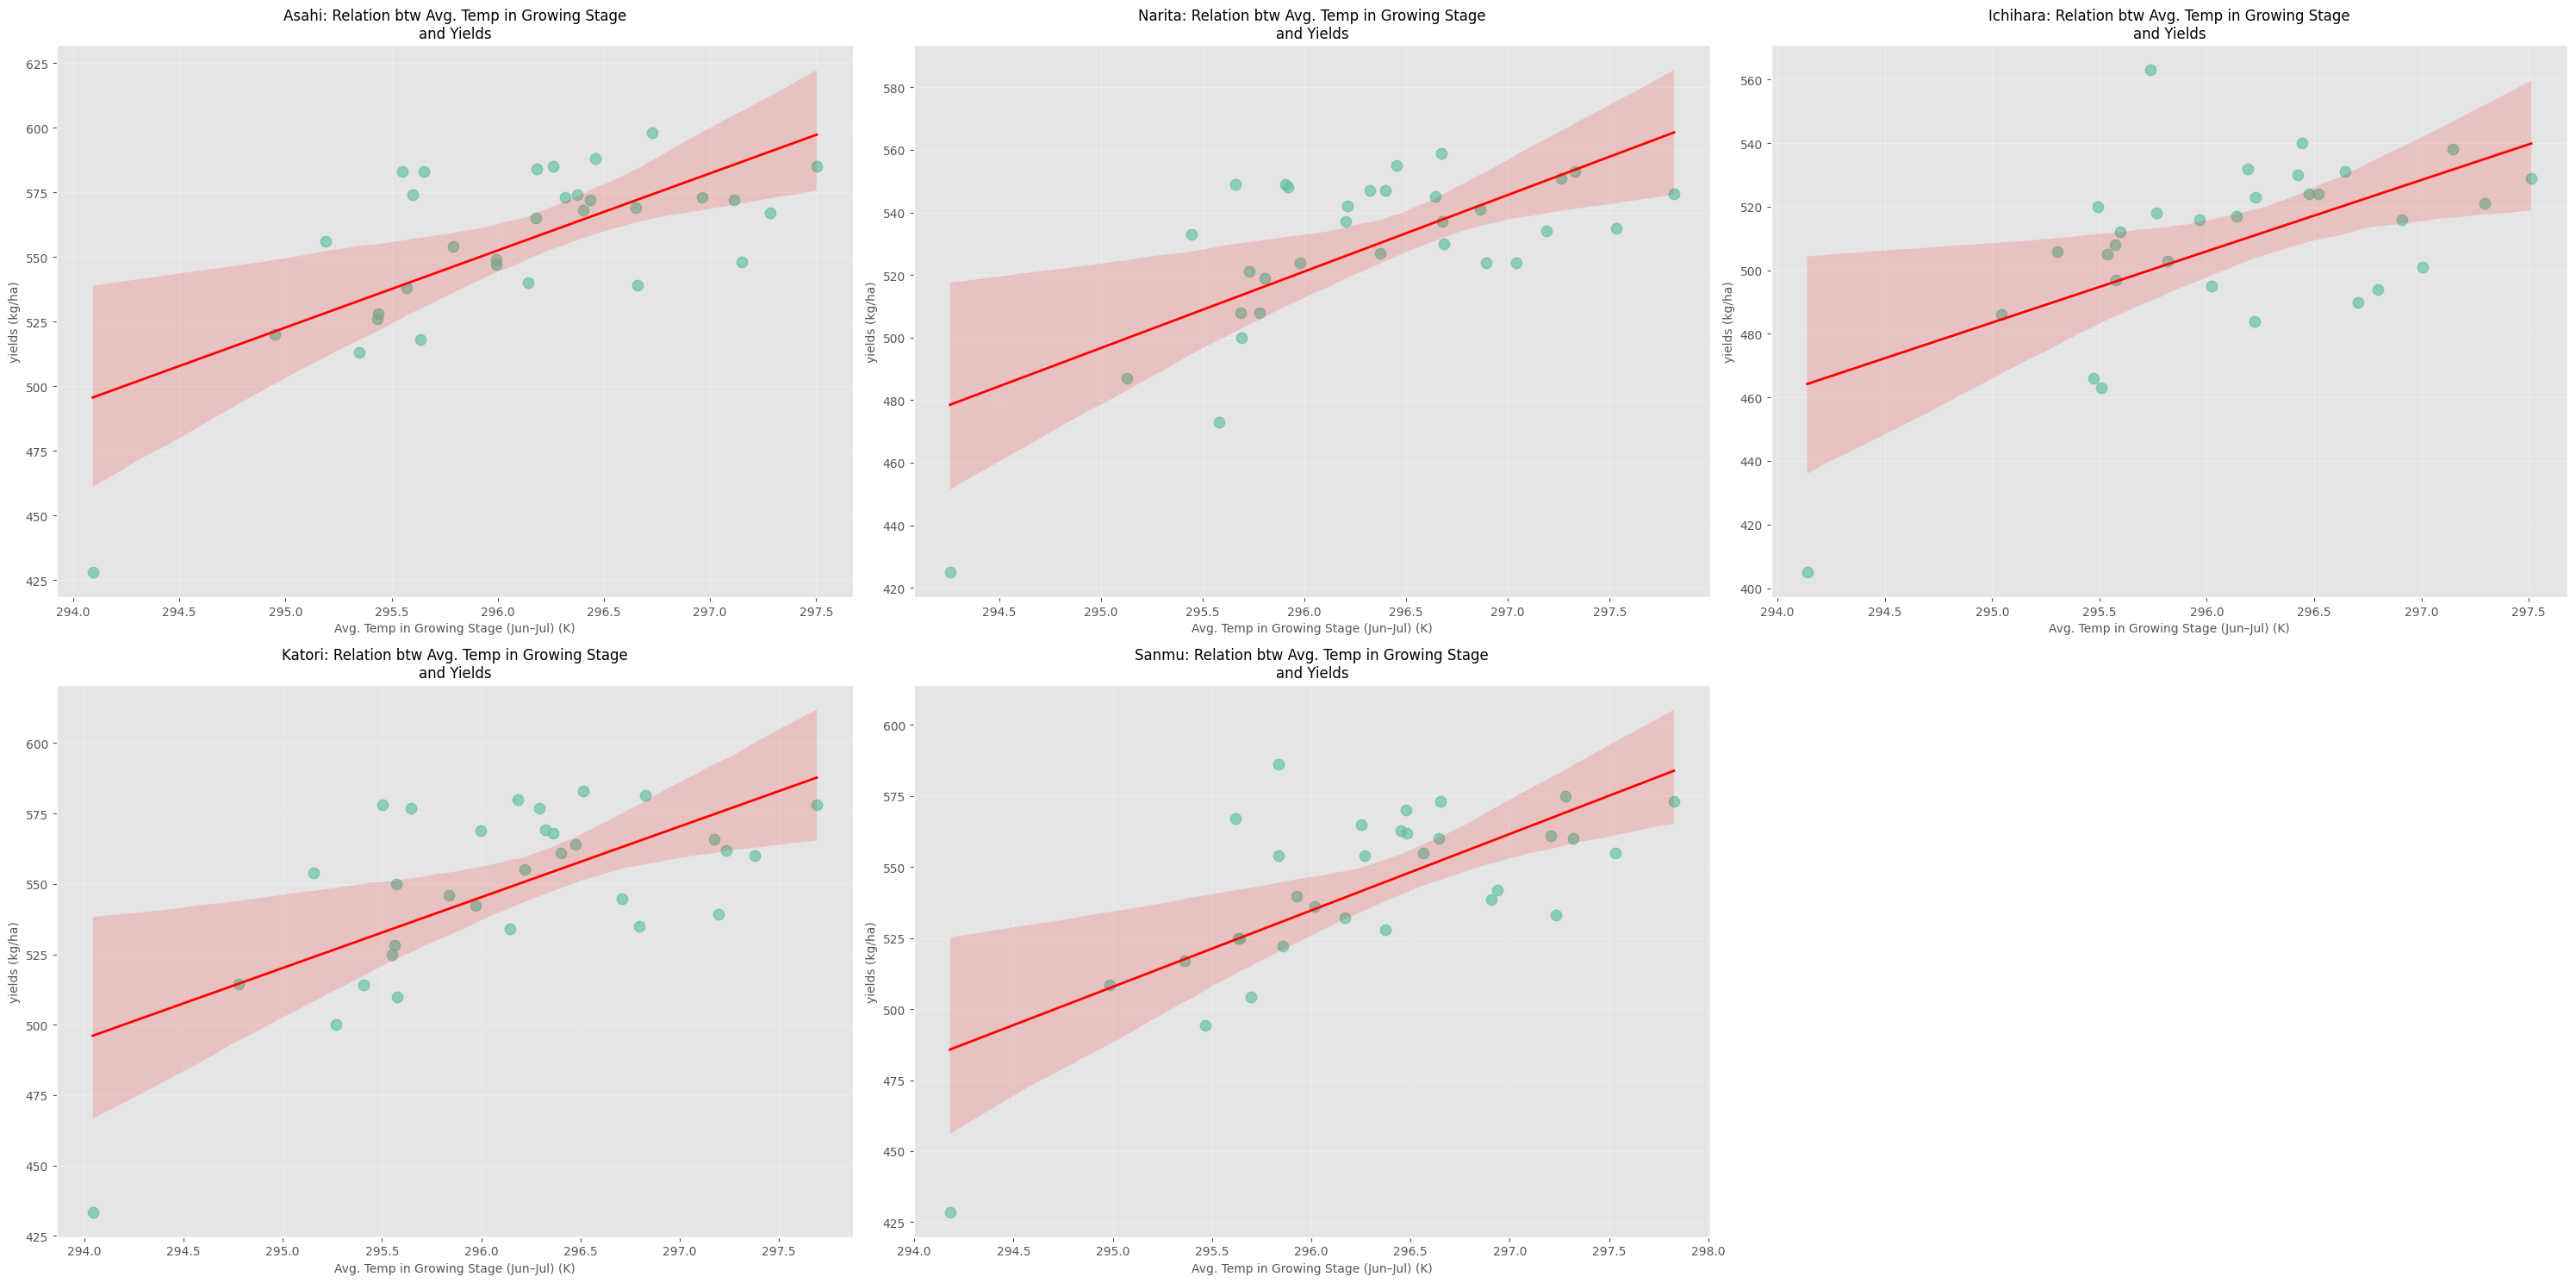

In [65]:
"""6. Scatter plot of significant climate factors and yields"""
# e.g. Avg. temp in growing stage (Jun–Jul) and yileds
plt.figure(figsize=(30, 15))

for i, region in enumerate(regions):
    region_data = all_data[all_data['region'] == region]
    
    plt.subplot(2, 3, i+1)
    
    # Scatter plot and trend line
    sns.regplot(x='growing_temp_2m', y='Yields', data=region_data, 
                scatter_kws={'s': 80, 'alpha': 0.7}, 
                line_kws={'color': 'red', 'linewidth': 2})
    
    plt.title(f'{region.capitalize()}: Relation btw Avg. Temp in Growing Stage\nand Yields', fontsize=12)
    plt.xlabel('Avg. Temp in Growing Stage (Jun–Jul) (K)', fontsize=10)
    plt.ylabel('yields (kg/ha)', fontsize=10)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

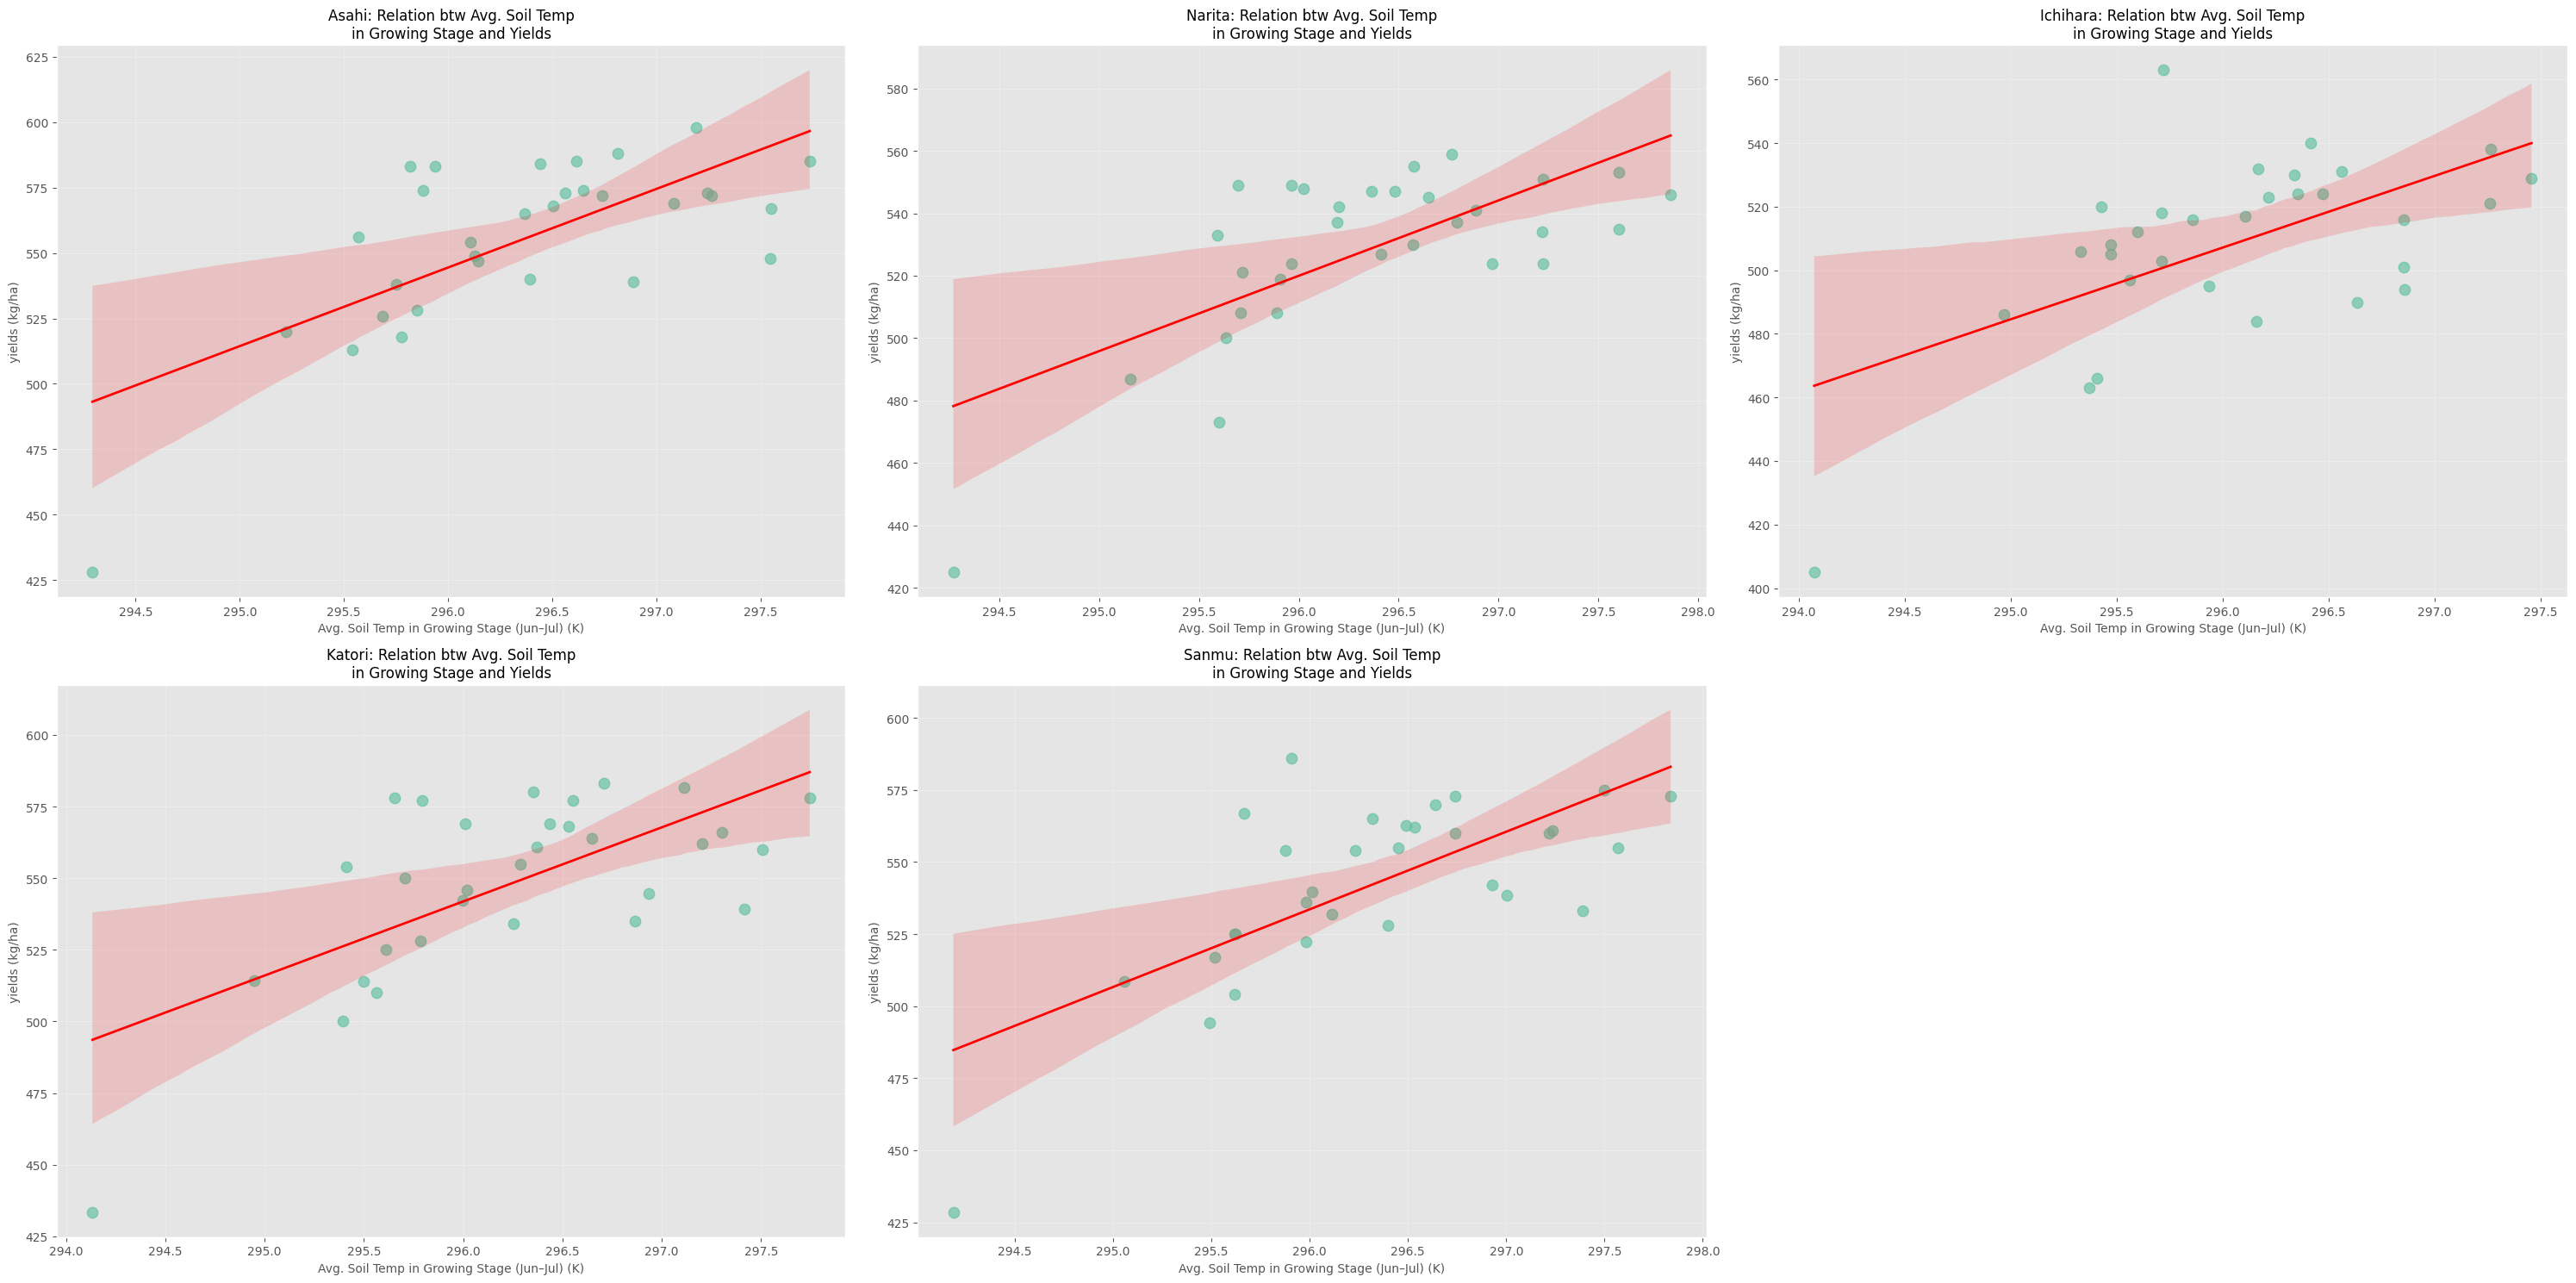

In [62]:
# Avg, soil temp in gwoming stage and yield
plt.figure(figsize=(30, 15))

for i, region in enumerate(regions):
    region_data = all_data[all_data['region'] == region]
    
    plt.subplot(2, 3, i+1)
    
    # Scatter plot and trend line
    sns.regplot(x='growing_soil_temp_l1', y='Yields', data=region_data, 
                scatter_kws={'s': 80, 'alpha': 0.7}, 
                line_kws={'color': 'red', 'linewidth': 2})
    
    plt.title(f'{region.capitalize()}: Relation btw Avg. Soil Temp\nin Growing Stage and Yields', fontsize=12)
    plt.xlabel('Avg. Soil Temp in Growing Stage (Jun–Jul) (K)', fontsize=10)
    plt.ylabel('yields (kg/ha)', fontsize=10)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

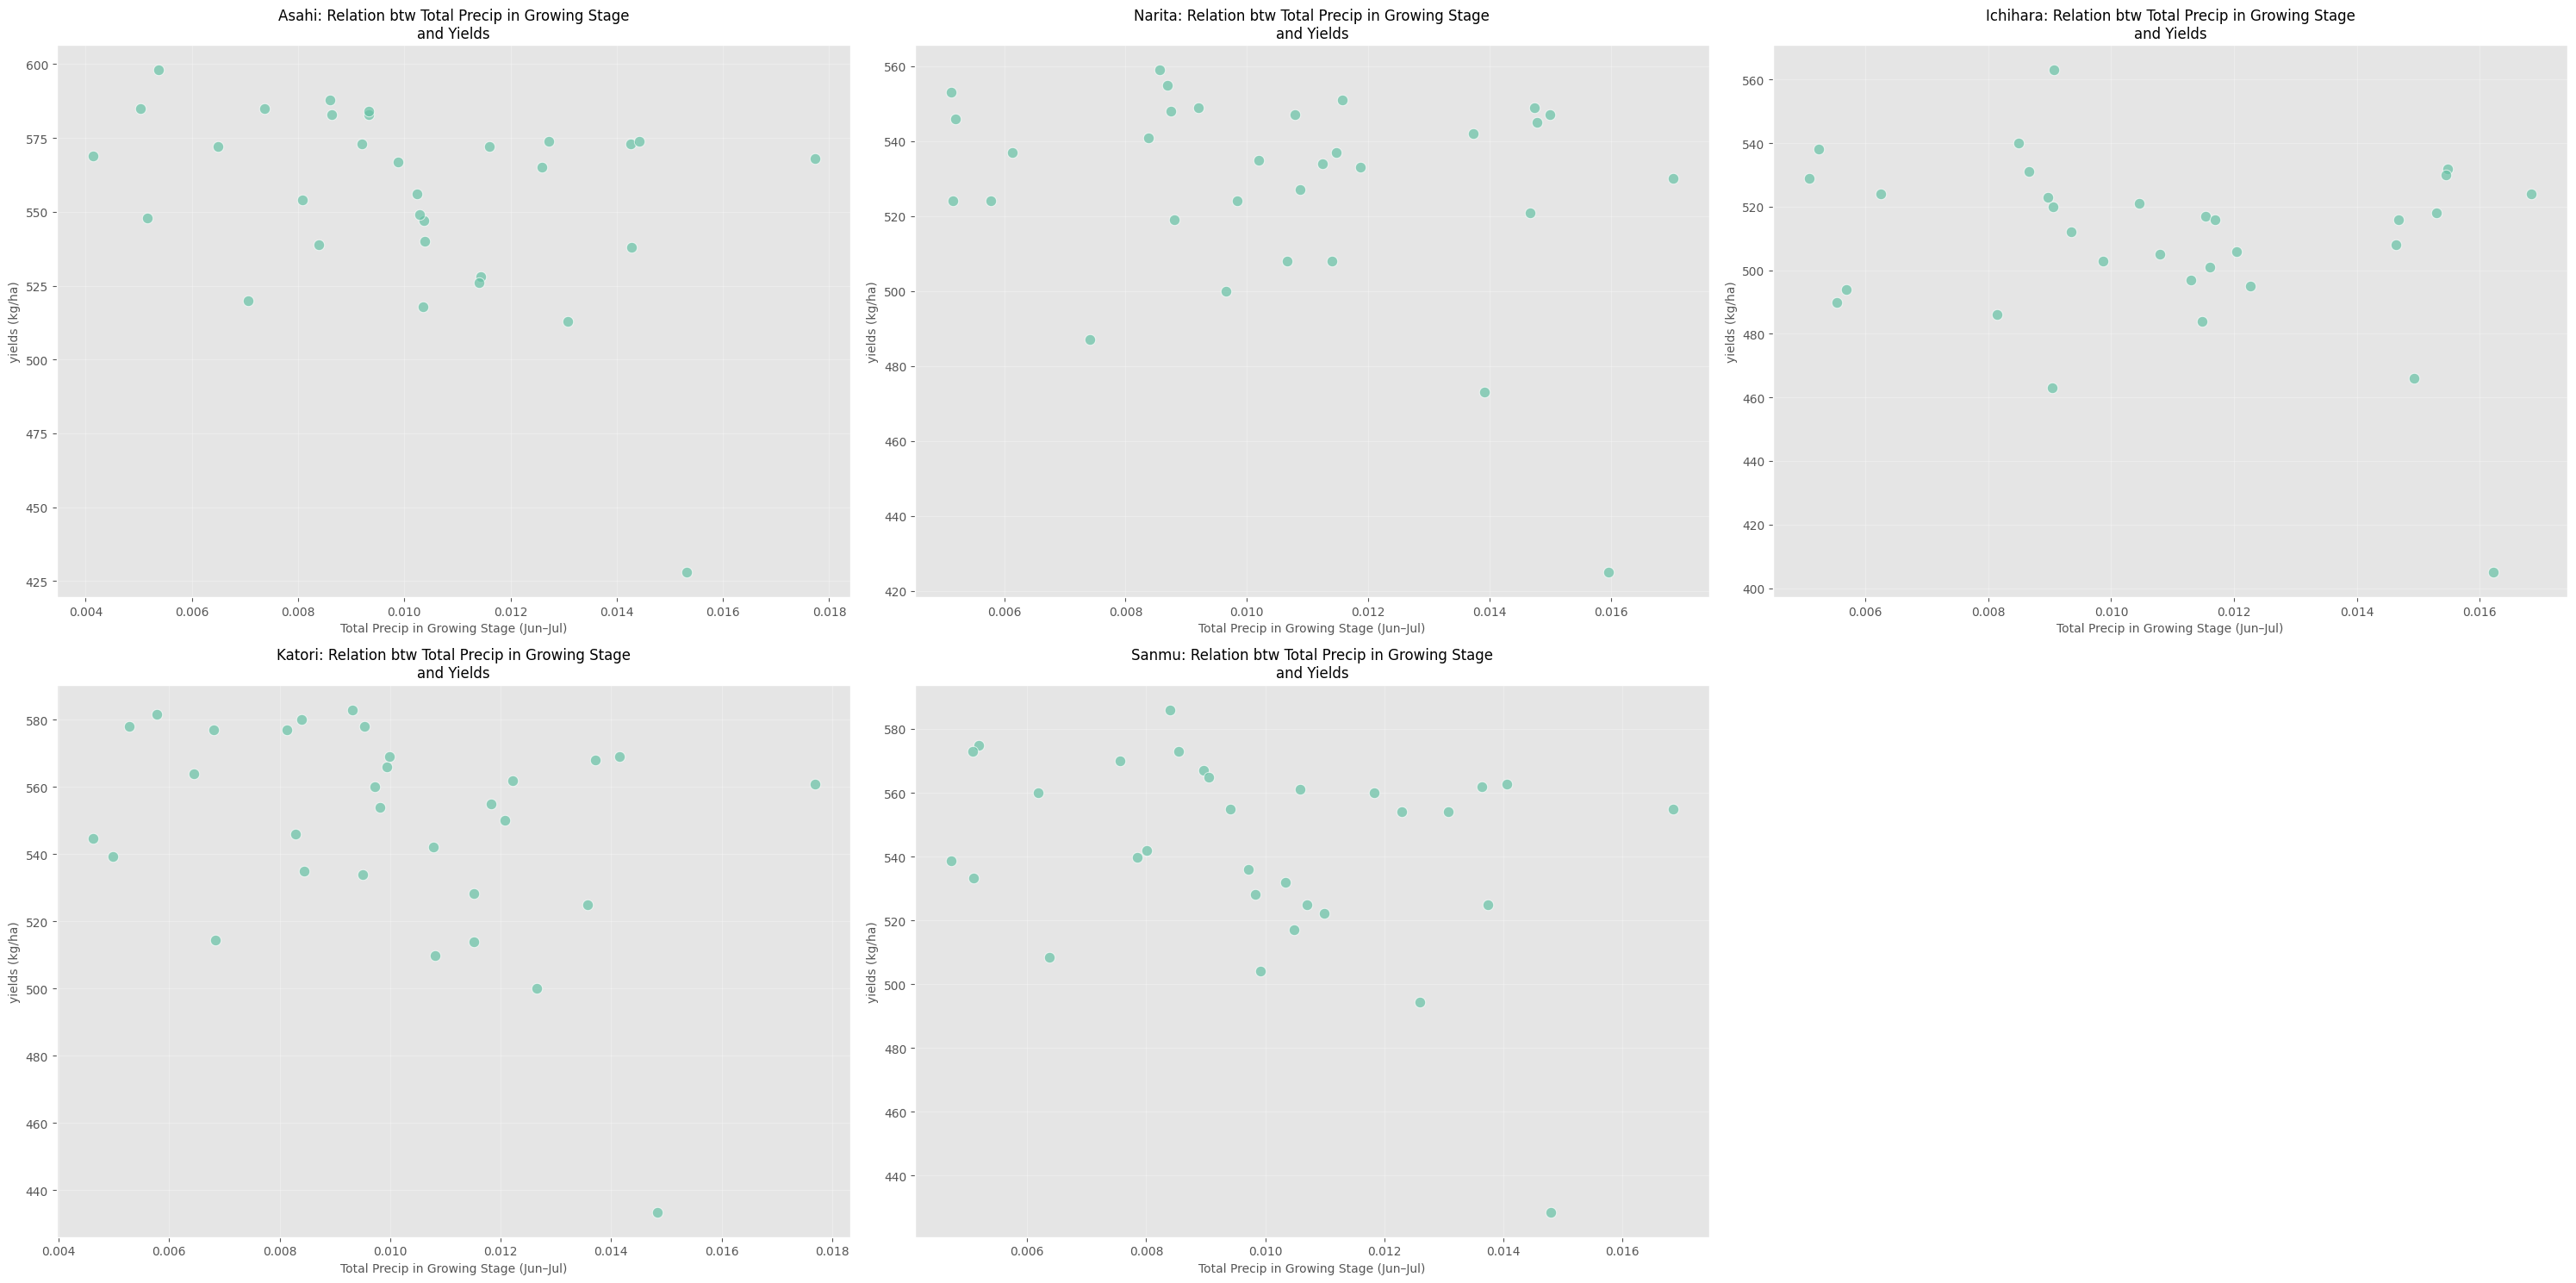

In [66]:
# Total rain in growing stage and yield
plt.figure(figsize=(30, 15))

for i, region in enumerate(regions):
    region_data = all_data[all_data['region'] == region]
    
    plt.subplot(2, 3, i+1)
    
    # Scatter plot and trend line
    sns.scatterplot(x='growing_total_rain', y='Yields', data=region_data, markers='o', s=80, alpha=0.7)
    
    plt.title(f'{region.capitalize()}: Relation btw Total Precip in Growing Stage\nand Yields', fontsize=12)
    plt.xlabel('Total Precip in Growing Stage (Jun–Jul)', fontsize=10)
    plt.ylabel('yields (kg/ha)', fontsize=10)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

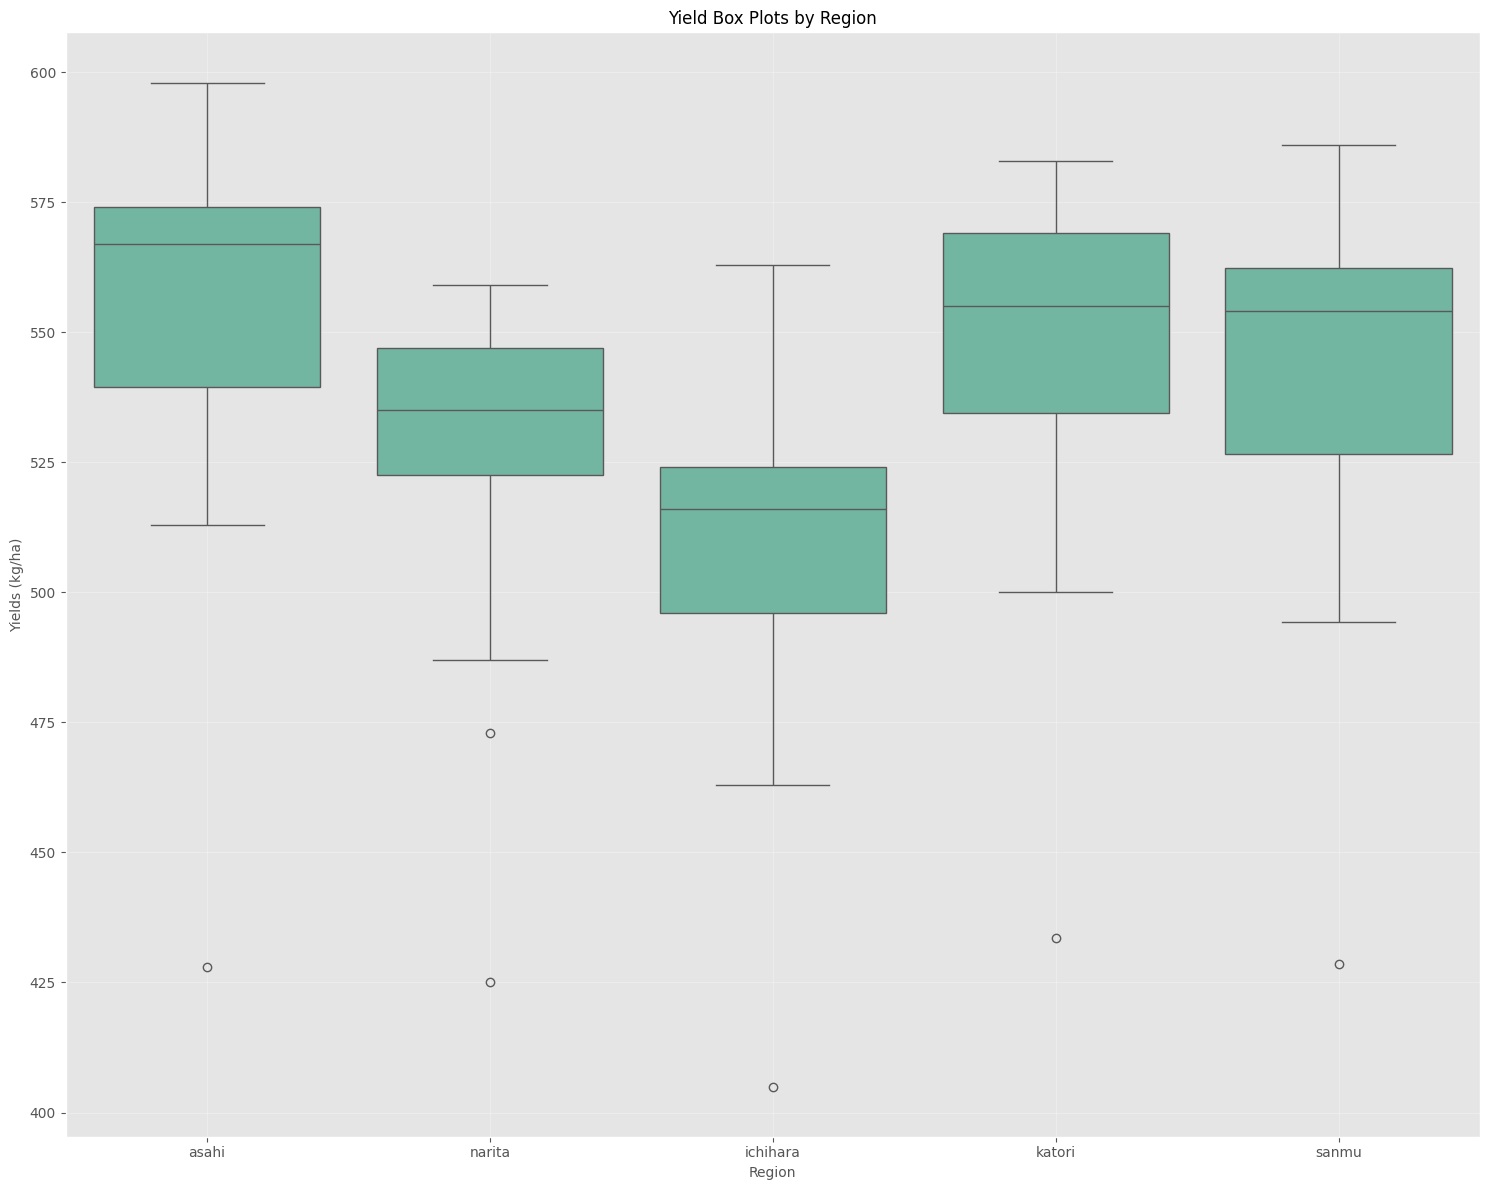

In [63]:
"""7. Box plot of yields by region"""

plt.figure(figsize=(15, 12))
sns.boxplot(x='region', y='Yields', data=all_data)
plt.title('Yield Box Plots by Region', fontsize=12)
plt.xlabel('Region', fontsize=10)
plt.ylabel('Yields (kg/ha)', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [67]:
"""8. Baseline model (linear regression) and evaluation"""

feature_cols = [
    'preparation_temp_2m', 'preparation_total_rain',
    'planting_temp_2m', 'planting_soil_temp_l1', 'planting_total_rain',
    'growing_temp_2m', 'growing_net_solar_radiation', 'growing_total_rain',
    'heading_temp_2m', 'heading_net_solar_radiation',
    'harvesting_temp_2m', 'harvesting_total_rain'
]

all_data_encoded = pd.get_dummies(all_data, columns=['region'], drop_first=True)

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = all_data_encoded[feature_cols + [col for col in all_data_encoded.columns if 'region_' in col]]
y = all_data_encoded['Yields']

# トレーニングセットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# モデルのトレーニング
model = LinearRegression()
model.fit(X_train, y_train)

# テストセットでの予測
y_pred = model.predict(X_test)

In [69]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [70]:
print(f"モデル評価結果:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

モデル評価結果:
MSE: 552.54
RMSE: 23.51
R²: 0.61


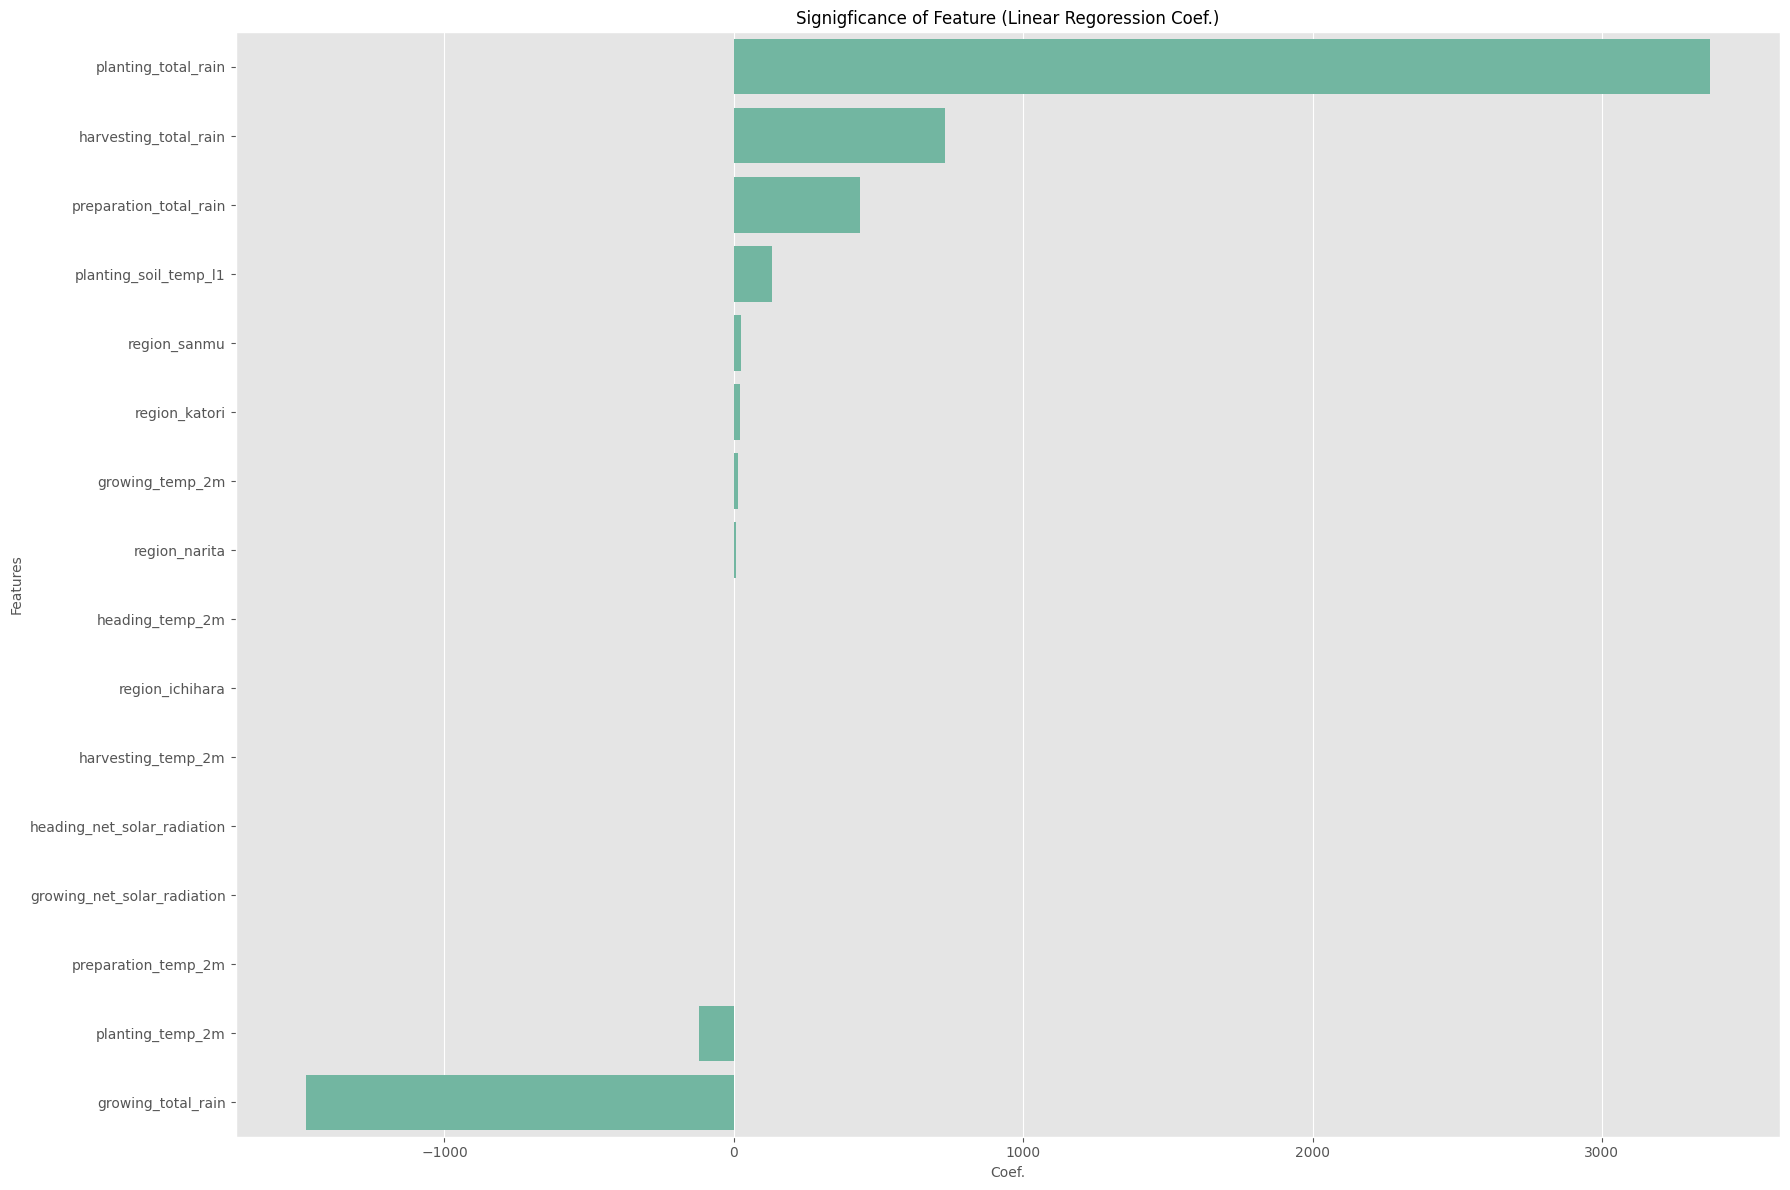

In [71]:
# 特徴量の重要度表示
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
coefficients = coefficients.sort_values('Coefficient', ascending=False)

plt.figure(figsize=(18, 12))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Signigficance of Feature (Linear Regoression Coef.)', fontsize=12)
plt.xlabel('Coef.', fontsize=10)
plt.ylabel('Features', fontsize=10)
plt.tight_layout()
plt.show()

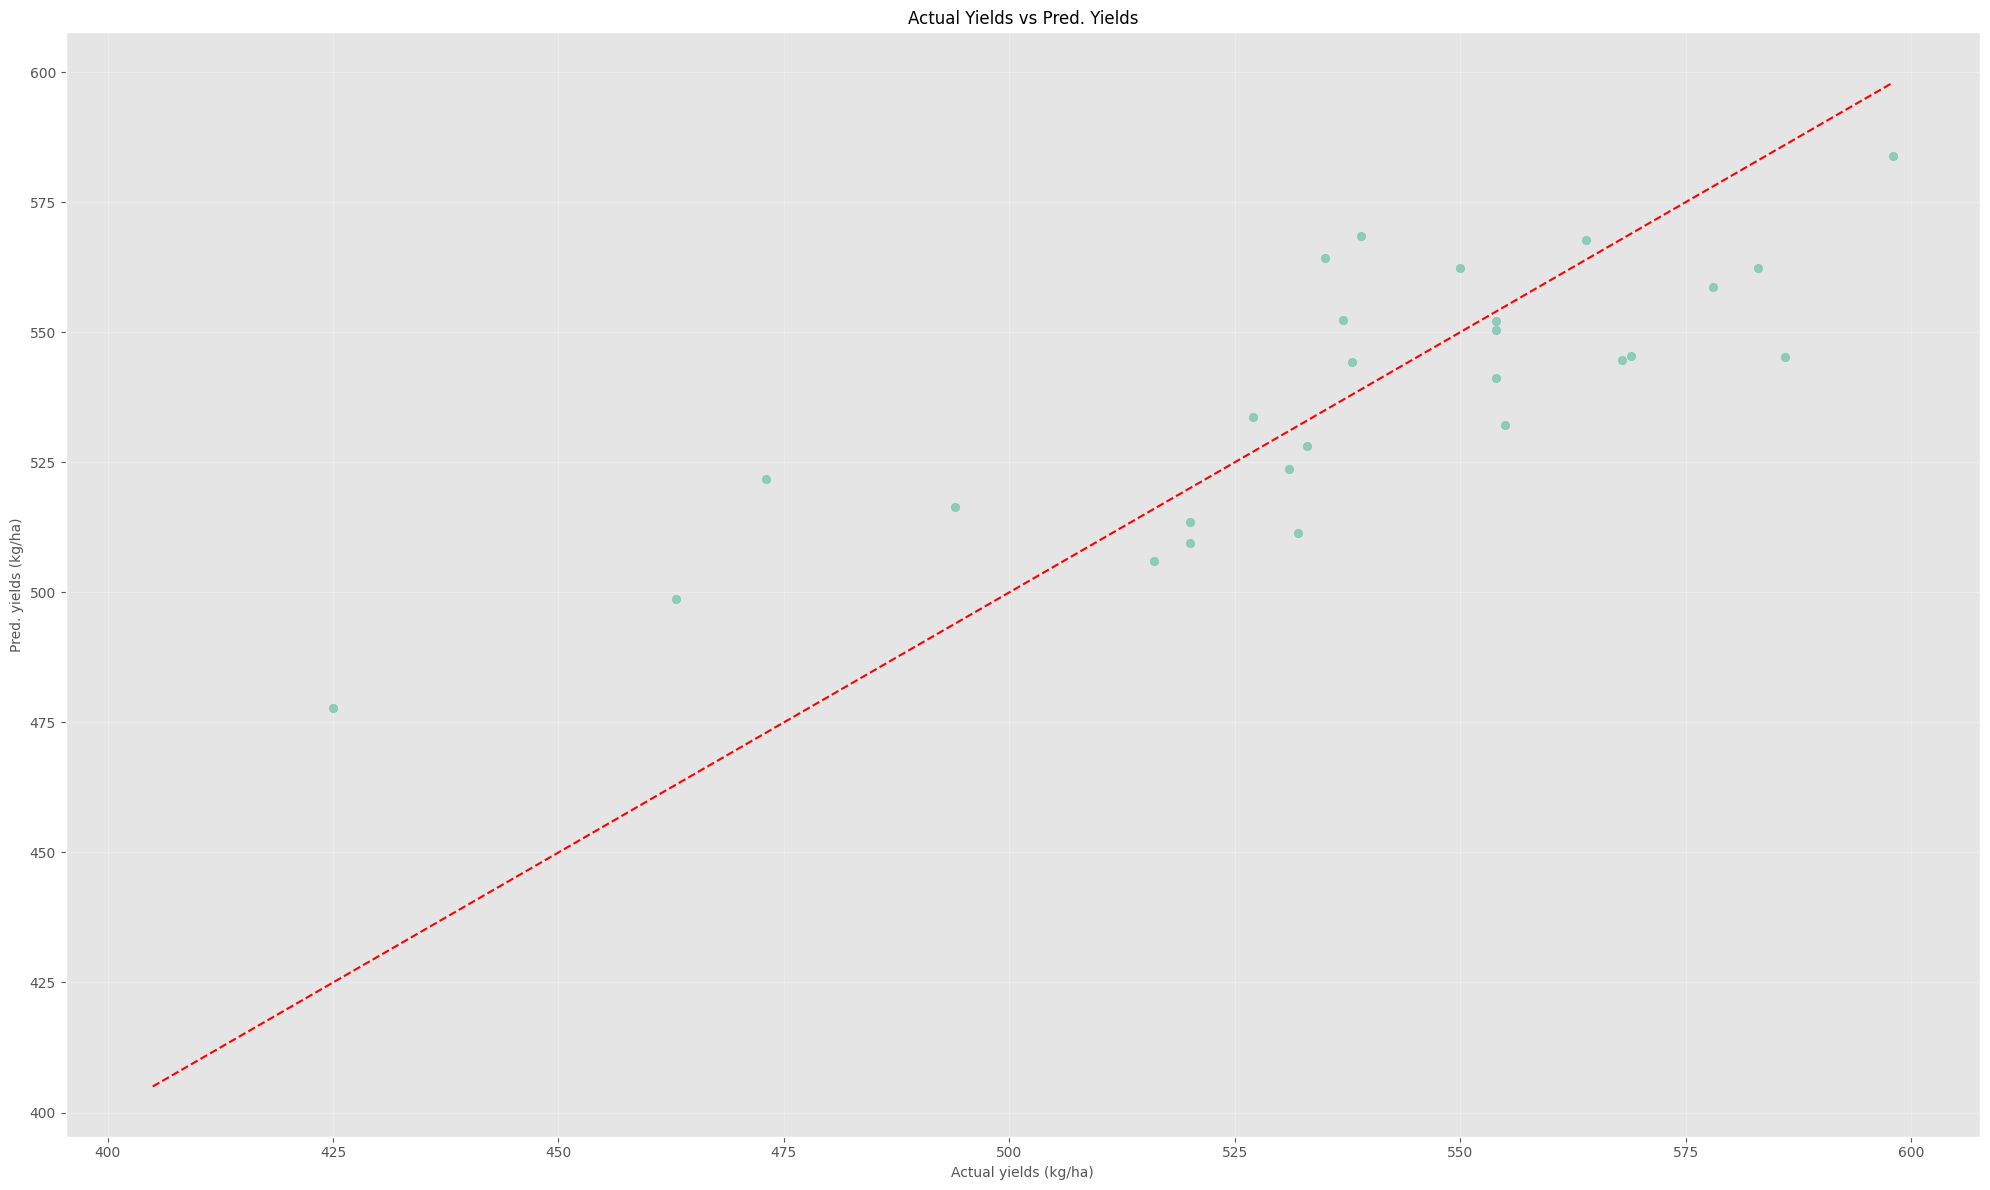

In [73]:
# 実際値と予測値の比較
plt.figure(figsize=(20, 12))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Actual Yields vs Pred. Yields', fontsize=12)
plt.xlabel('Actual yields (kg/ha)', fontsize=10)
plt.ylabel('Pred. yields (kg/ha)', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
